In [8]:
import torch, torchvision
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
import PIL
import cv2
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
###################################################################################################################### This notebook implements the AutoEncoder on the MNIST data. 
###################################################################################################################### Ayush Mittal (myself) is the author of this hobby experiments

In [2]:
# define the dataset object

device = ["cuda" if torch.cuda.is_available() else "cpu"][0]
train_dataset = torchvision.datasets.MNIST(root = "./", train = True, transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]
))
val_dataset = torchvision.datasets.MNIST(root = "./", train = False, download = True, transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ]))

In [13]:
# define the model architecture

# -1, 1, 28, 28
# -1, 8, 14, 14
# -1, 16, 7, 7
#-1,  32, 1, 1 

class AE(nn.Module):
    def __init__(self, latent_dim = 32):
        super().__init__()

        self.latent_dim = latent_dim

        # encoder
        Eblock = []
        in_channels = 1
        for i in range(3):
            out_channels = 2**(3+i)
            Eblock.append(nn.Sequential(
                                        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
                                        nn.BatchNorm2d(out_channels),
                                        nn.LeakyReLU(0.2, inplace=True)
                                        ))
            in_channels = out_channels

        self.out_channels = out_channels
        self.Encoder = nn.Sequential(*Eblock)

        # latent variable via linear layer
        self.linear_donw = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(128, self.latent_dim),
                                    nn.BatchNorm1d(self.latent_dim),
                                    nn.LeakyReLU(0.2, inplace=True)
                                    )

        self.linear_up = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(self.latent_dim, 128),
                                    nn.BatchNorm1d(128),
                                    nn.LeakyReLU(0.2, inplace=True)
                                    
                                    )
        # Decoder
        Dblock = []
        param = np.array([[3,1,0],
                          [3,2,1],
                          [4,2,1],
                          [4,2,1]])
        in_channels = self.out_channels
        for i in range(4):
            out_channels = int(in_channels/2)
            if i == 3:
                out_channels = int(in_channels/4)
            Dblock.append(nn.Sequential(
                                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=param[i][0], stride=param[i][1], padding=param[i][2]),
                                        nn.BatchNorm2d(out_channels),
                                        nn.LeakyReLU(0.2, inplace=True)
                                        #nn.Tanh()
                                        ))
            in_channels = out_channels
        
        self.Decoder = nn.Sequential(*Dblock)
        
    def forward(self,x):
        x = self.Encoder(x)
        x = self.linear_donw(x)
        x = self.linear_up(x)
        x = x.view(-1, 32, 2, 2)
        x = self.Decoder(x)
        return x

model = AE(latent_dim = 32).to(device)

print(model(torch.rand(4,1,28,28).to(device)).shape)

torch.Size([4, 1, 28, 28])


In [19]:
# setting up the hyperparams ;)
epoch = 100
batch_size = 64
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss() #l2 loss for AE; l2 + KLD for VAE





In [20]:
# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle= True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(val_dataset), shuffle= False, pin_memory=True)

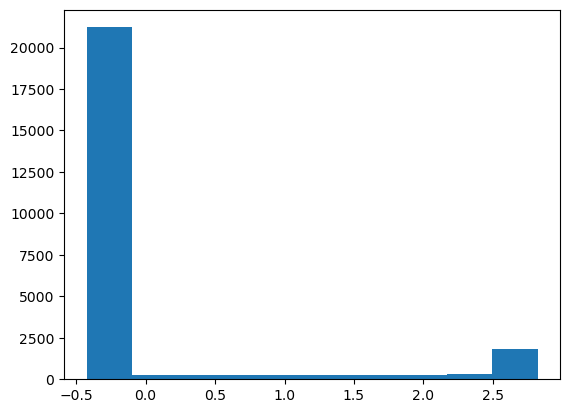

In [18]:
# confirm the distribution of the input data to the model

for (img, target) in train_loader:
    img = img.numpy()
    plt.hist(img.flatten())
    break

In [21]:
# training loop
train_loss = []
val_loss = []
for i in tqdm(range(epoch)):
    model.train()
    
    total_loss = 0.00
    for bx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
    
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        loss = loss_fn(output, images)#loss_fn(output, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # log losses
    print(f"Training Loss:{total_loss/bx}")
    train_loss.append(total_loss/bx)
    
    # validation step
    model.eval()
    
    for bx, (images, targets) in enumerate(val_loader):
        images, targets = images.to(device), targets.to(device) 

        output = model(images)
        loss = loss_fn(output, images)#loss_fn(output, images)
    
    print(f"Validation Loss:{loss}")
    val_loss.append(loss)
        
    

  0%|                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]

Training Loss:0.6829405288622499


  1%|█▋                                                                                                                                                                       | 1/100 [00:35<58:42, 35.58s/it]

Validation Loss:0.45159798860549927
Training Loss:0.40695815257481605


  2%|███▍                                                                                                                                                                     | 2/100 [01:07<54:29, 33.36s/it]

Validation Loss:0.3521791696548462
Training Loss:0.33945969233772416


  3%|█████                                                                                                                                                                    | 3/100 [01:39<52:52, 32.71s/it]

Validation Loss:0.30252277851104736
Training Loss:0.30178307981221375


  4%|██████▊                                                                                                                                                                  | 4/100 [02:11<51:49, 32.39s/it]

Validation Loss:0.2704378068447113
Training Loss:0.2750782573172224


  5%|████████▍                                                                                                                                                                | 5/100 [02:43<51:05, 32.27s/it]

Validation Loss:0.24684137105941772
Training Loss:0.25386820159446977


  6%|██████████▏                                                                                                                                                              | 6/100 [03:15<50:16, 32.09s/it]

Validation Loss:0.22642900049686432
Training Loss:0.23587666059125575


  7%|███████████▊                                                                                                                                                             | 7/100 [03:46<49:39, 32.03s/it]

Validation Loss:0.20970678329467773
Training Loss:0.22071139005548546


  8%|█████████████▌                                                                                                                                                           | 8/100 [04:18<48:58, 31.94s/it]

Validation Loss:0.19535280764102936
Training Loss:0.20812005412107853


  9%|███████████████▏                                                                                                                                                         | 9/100 [04:50<48:30, 31.98s/it]

Validation Loss:0.18366779386997223
Training Loss:0.1974781814767813


 10%|████████████████▊                                                                                                                                                       | 10/100 [05:22<47:54, 31.94s/it]

Validation Loss:0.17335379123687744
Training Loss:0.18836713622830084


 11%|██████████████████▍                                                                                                                                                     | 11/100 [05:54<47:22, 31.94s/it]

Validation Loss:0.1651000827550888
Training Loss:0.1806589536599441


 12%|████████████████████▏                                                                                                                                                   | 12/100 [06:26<46:45, 31.88s/it]

Validation Loss:0.15793411433696747
Training Loss:0.1739558858226432


 13%|█████████████████████▊                                                                                                                                                  | 13/100 [06:58<46:10, 31.85s/it]

Validation Loss:0.1513809710741043
Training Loss:0.16860527544418547


 14%|███████████████████████▌                                                                                                                                                | 14/100 [07:29<45:36, 31.82s/it]

Validation Loss:0.14647416770458221
Training Loss:0.16380295526383398


 15%|█████████████████████████▏                                                                                                                                              | 15/100 [08:01<45:09, 31.88s/it]

Validation Loss:0.14182311296463013
Training Loss:0.15929260869036363


 16%|██████████████████████████▉                                                                                                                                             | 16/100 [08:33<44:37, 31.88s/it]

Validation Loss:0.1379847526550293
Training Loss:0.15582828223705292


 17%|████████████████████████████▌                                                                                                                                           | 17/100 [09:05<44:07, 31.90s/it]

Validation Loss:0.1346650868654251
Training Loss:0.15238867361364905


 18%|██████████████████████████████▏                                                                                                                                         | 18/100 [09:37<43:36, 31.91s/it]

Validation Loss:0.13122762739658356
Training Loss:0.14962371590615844


 19%|███████████████████████████████▉                                                                                                                                        | 19/100 [10:09<43:04, 31.91s/it]

Validation Loss:0.12839148938655853
Training Loss:0.14669193565972713


 20%|█████████████████████████████████▌                                                                                                                                      | 20/100 [10:41<42:28, 31.86s/it]

Validation Loss:0.12581782042980194
Training Loss:0.1443561181950849


 21%|███████████████████████████████████▎                                                                                                                                    | 21/100 [11:13<41:57, 31.87s/it]

Validation Loss:0.12370019406080246
Training Loss:0.1417963233564681


 22%|████████████████████████████████████▉                                                                                                                                   | 22/100 [11:44<41:22, 31.82s/it]

Validation Loss:0.12119045853614807
Training Loss:0.13953979723672347


 23%|██████████████████████████████████████▋                                                                                                                                 | 23/100 [12:16<40:54, 31.87s/it]

Validation Loss:0.11928669363260269
Training Loss:0.13778360959305452


 24%|████████████████████████████████████████▎                                                                                                                               | 24/100 [12:48<40:17, 31.81s/it]

Validation Loss:0.11783535033464432
Training Loss:0.13561892918168925


 25%|██████████████████████████████████████████                                                                                                                              | 25/100 [13:20<39:48, 31.85s/it]

Validation Loss:0.11543596535921097
Training Loss:0.13370280586413666


 26%|███████████████████████████████████████████▋                                                                                                                            | 26/100 [13:52<39:13, 31.80s/it]

Validation Loss:0.11382640153169632
Training Loss:0.1322067249864499


 27%|█████████████████████████████████████████████▎                                                                                                                          | 27/100 [14:24<38:44, 31.84s/it]

Validation Loss:0.1117362380027771
Training Loss:0.13026324627779845


 28%|███████████████████████████████████████████████                                                                                                                         | 28/100 [14:55<37:59, 31.66s/it]

Validation Loss:0.11064361780881882
Training Loss:0.12901171963968042


 29%|████████████████████████████████████████████████▋                                                                                                                       | 29/100 [15:26<37:24, 31.61s/it]

Validation Loss:0.10862791538238525
Training Loss:0.1273014224596568


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 30/100 [15:58<36:45, 31.51s/it]

Validation Loss:0.10748612880706787
Training Loss:0.12604475042831428


 31%|████████████████████████████████████████████████████                                                                                                                    | 31/100 [16:29<36:14, 31.51s/it]

Validation Loss:0.10608324408531189
Training Loss:0.12452929997329651


 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 32/100 [17:00<35:37, 31.43s/it]

Validation Loss:0.10453086346387863
Training Loss:0.12301765886416685


 33%|███████████████████████████████████████████████████████▍                                                                                                                | 33/100 [17:32<35:04, 31.41s/it]

Validation Loss:0.1032053604722023
Training Loss:0.12176784473046931


 34%|█████████████████████████████████████████████████████████                                                                                                               | 34/100 [18:03<34:30, 31.37s/it]

Validation Loss:0.1022205799818039
Training Loss:0.1205523204189609


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 35/100 [18:34<33:59, 31.38s/it]

Validation Loss:0.10079987347126007
Training Loss:0.11933670085611313


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 36/100 [19:06<33:26, 31.35s/it]

Validation Loss:0.09985226392745972
Training Loss:0.11844476826862693


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 37/100 [19:37<32:56, 31.37s/it]

Validation Loss:0.09875304251909256
Training Loss:0.11741378912135657


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 38/100 [20:09<32:26, 31.40s/it]

Validation Loss:0.09812699258327484
Training Loss:0.11642980483323813


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 39/100 [20:40<32:01, 31.49s/it]

Validation Loss:0.09713870286941528
Training Loss:0.11532196031213443


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 40/100 [21:12<31:26, 31.44s/it]

Validation Loss:0.09613022953271866
Training Loss:0.11468421885686089


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 41/100 [21:43<30:53, 31.41s/it]

Validation Loss:0.09537271410226822
Training Loss:0.1137355967894944


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 42/100 [22:14<30:21, 31.41s/it]

Validation Loss:0.0948001891374588
Training Loss:0.113324368768148


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 43/100 [22:46<29:50, 31.42s/it]

Validation Loss:0.094425730407238
Training Loss:0.1123990368579088


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 44/100 [23:17<29:18, 31.40s/it]

Validation Loss:0.09354165941476822
Training Loss:0.11140766740640429


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 45/100 [23:48<28:46, 31.38s/it]

Validation Loss:0.09272995591163635
Training Loss:0.11082830559164127


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 46/100 [24:20<28:14, 31.38s/it]

Validation Loss:0.09261877834796906
Training Loss:0.11074576940359657


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 47/100 [24:51<27:43, 31.39s/it]

Validation Loss:0.09153907746076584
Training Loss:0.11001284732985267


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 48/100 [25:22<27:09, 31.33s/it]

Validation Loss:0.09128886461257935
Training Loss:0.10941952902708389


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 49/100 [25:54<26:39, 31.36s/it]

Validation Loss:0.09077556431293488
Training Loss:0.10886237239156996


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 50/100 [26:25<26:05, 31.32s/it]

Validation Loss:0.09036026895046234
Training Loss:0.10847325247723366


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 51/100 [26:56<25:34, 31.31s/it]

Validation Loss:0.09010832756757736
Training Loss:0.10791483360840645


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 52/100 [27:28<25:02, 31.29s/it]

Validation Loss:0.08912719786167145
Training Loss:0.1077085087908752


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 53/100 [27:59<24:31, 31.30s/it]

Validation Loss:0.08858843892812729
Training Loss:0.10697144224619534


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 54/100 [28:30<23:57, 31.25s/it]

Validation Loss:0.08831793814897537
Training Loss:0.10635983192519928


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 55/100 [29:02<23:39, 31.54s/it]

Validation Loss:0.088408462703228
Training Loss:0.10593072852177451


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 56/100 [29:35<23:28, 32.02s/it]

Validation Loss:0.08764520287513733
Training Loss:0.10548909796499265


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 57/100 [30:07<22:48, 31.83s/it]

Validation Loss:0.08746041357517242
Training Loss:0.10540526370610347


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 58/100 [30:38<22:10, 31.67s/it]

Validation Loss:0.08707952499389648
Training Loss:0.1047261470378145


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 59/100 [31:09<21:35, 31.59s/it]

Validation Loss:0.08706385642290115
Training Loss:0.10444088489326113


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 60/100 [31:41<20:58, 31.46s/it]

Validation Loss:0.08627359569072723
Training Loss:0.1042335582628703


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 61/100 [32:12<20:27, 31.48s/it]

Validation Loss:0.08553172647953033
Training Loss:0.10381952385351523


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 62/100 [32:44<19:54, 31.45s/it]

Validation Loss:0.08547557145357132
Training Loss:0.10374841562361957


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 63/100 [33:15<19:23, 31.45s/it]

Validation Loss:0.08514266461133957
Training Loss:0.10301788126614457


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 64/100 [33:46<18:51, 31.43s/it]

Validation Loss:0.08490175008773804
Training Loss:0.10319100278196111


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 65/100 [34:18<18:19, 31.41s/it]

Validation Loss:0.08463984727859497
Training Loss:0.10277145668434867


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 66/100 [34:49<17:47, 31.40s/it]

Validation Loss:0.08432047814130783
Training Loss:0.10262761328651658


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 67/100 [35:21<17:17, 31.43s/it]

Validation Loss:0.08452395349740982
Training Loss:0.10230931708054455


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 68/100 [35:52<16:43, 31.36s/it]

Validation Loss:0.08396250009536743
Training Loss:0.10214908813049851


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 69/100 [36:23<16:13, 31.41s/it]

Validation Loss:0.08368685841560364
Training Loss:0.10139426235964356


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 70/100 [36:55<15:41, 31.40s/it]

Validation Loss:0.08335493505001068
Training Loss:0.10129820629397732


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 71/100 [37:26<15:12, 31.46s/it]

Validation Loss:0.08293735235929489
Training Loss:0.10124741069248926


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 72/100 [37:58<14:40, 31.45s/it]

Validation Loss:0.08313612639904022
Training Loss:0.10080047005046013


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 73/100 [38:29<14:08, 31.43s/it]

Validation Loss:0.08306821435689926
Training Loss:0.10069426486274603


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 74/100 [39:00<13:35, 31.38s/it]

Validation Loss:0.08266063034534454
Training Loss:0.10053649064443664


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 75/100 [39:32<13:05, 31.41s/it]

Validation Loss:0.08286476880311966
Training Loss:0.10036285388558754


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 76/100 [40:03<12:33, 31.41s/it]

Validation Loss:0.08254048228263855
Training Loss:0.100244339201659


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 77/100 [40:35<12:03, 31.45s/it]

Validation Loss:0.08220996707677841
Training Loss:0.09991865240140811


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 78/100 [41:06<11:31, 31.41s/it]

Validation Loss:0.0818217545747757
Training Loss:0.09991500715117826


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 79/100 [41:38<11:00, 31.43s/it]

Validation Loss:0.08154113590717316
Training Loss:0.09972956953938004


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 80/100 [42:09<10:27, 31.37s/it]

Validation Loss:0.08183549344539642
Training Loss:0.09921764216625321


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 81/100 [42:40<09:56, 31.38s/it]

Validation Loss:0.0815175473690033
Training Loss:0.0994713432935793


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 82/100 [43:11<09:23, 31.32s/it]

Validation Loss:0.08199562132358551
Training Loss:0.09932515324911415


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 83/100 [43:43<08:53, 31.37s/it]

Validation Loss:0.08119891583919525
Training Loss:0.09874114909446863


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 84/100 [44:14<08:21, 31.37s/it]

Validation Loss:0.08140374720096588
Training Loss:0.09905261116195768


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 85/100 [44:46<07:50, 31.38s/it]

Validation Loss:0.08153379708528519
Training Loss:0.09864493030875826


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 86/100 [45:17<07:18, 31.35s/it]

Validation Loss:0.08145132660865784
Training Loss:0.09876137710272821


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 87/100 [45:48<06:47, 31.38s/it]

Validation Loss:0.08095798641443253
Training Loss:0.09814523335391201


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 88/100 [46:20<06:16, 31.36s/it]

Validation Loss:0.08041251450777054
Training Loss:0.09849447452462216


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 89/100 [46:51<05:44, 31.36s/it]

Validation Loss:0.08040433377027512
Training Loss:0.09841066641035304


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 90/100 [47:22<05:12, 31.24s/it]

Validation Loss:0.08075933903455734
Training Loss:0.09815030564079925


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 91/100 [47:53<04:41, 31.29s/it]

Validation Loss:0.08022449165582657
Training Loss:0.09774843459449939


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 92/100 [48:25<04:10, 31.26s/it]

Validation Loss:0.08007345348596573
Training Loss:0.09756470031901128


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 93/100 [48:56<03:38, 31.28s/it]

Validation Loss:0.0805477499961853
Training Loss:0.09778318722735346


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 94/100 [49:27<03:07, 31.28s/it]

Validation Loss:0.07970724254846573
Training Loss:0.09776819607077948


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 95/100 [49:59<02:36, 31.34s/it]

Validation Loss:0.07987888902425766
Training Loss:0.09745630392906124


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [50:30<02:05, 31.28s/it]

Validation Loss:0.0795338973402977
Training Loss:0.09755269880928377


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 97/100 [51:01<01:34, 31.33s/it]

Validation Loss:0.07955276966094971
Training Loss:0.09703449410333705


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [51:33<01:02, 31.28s/it]

Validation Loss:0.0794445127248764
Training Loss:0.09704241059569438


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [52:04<00:31, 31.29s/it]

Validation Loss:0.07907932251691818
Training Loss:0.09698600342682102


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [52:35<00:00, 31.56s/it]

Validation Loss:0.07944981753826141


In [ ]:
plt.plot([i for i in range(epoch)], train_loss)
plt.plot([i for i in range(epoch)], val_loss)

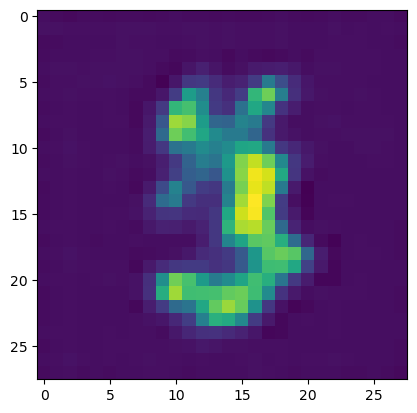

In [67]:
test_x = torch.rand(1, 32, 2, 2).to(device)
test_y = model.Decoder(test_x).detach()

inv_trans = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))
test_y = inv_trans(test_y)
test_y = test_y.cpu().numpy().reshape(28,28, 1)
test_y = (test_y*255).astype(int)
#plt.hist(test_y.flatten())
plt.imshow(test_y)
plt.show()
